In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from scipy.stats import gaussian_kde
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('clean_loans50k.csv', index_col=0)

In [3]:
df.head().T

,0,1,2,3,4
loanID,188861,517703,268587,579902,617630
amount,8000.0,11000.0,35000.0,20000.0,12000.0
term,36 months,36 months,36 months,60 months,60 months
rate,0.14,0.1,0.15,0.12,0.12
payment,272.07,354.89,1220.33,447.83,266.88
grade,C,B,D,C,B
employment,Warehouseman,Vice President,Owner/Attorney,Analyst,medical technician
length,3 years,10+ years,10+ years,2 years,10+ years
home,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE
income,49966.0,50000.0,360000.0,60000.0,64000.0


**Quite a large amount of the info is text data, rather than numerical.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49996 entries, 0 to 49998
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanID       49996 non-null  int64  
 1   amount       49996 non-null  float64
 2   term         49996 non-null  object 
 3   rate         49996 non-null  float64
 4   payment      49996 non-null  float64
 5   grade        49996 non-null  object 
 6   employment   49996 non-null  object 
 7   length       49996 non-null  object 
 8   home         49996 non-null  object 
 9   income       49996 non-null  float64
 10  verified     49996 non-null  object 
 11  status       49996 non-null  object 
 12  reason       49996 non-null  object 
 13  state        49996 non-null  object 
 14  debtIncRat   49996 non-null  float64
 15  delinq2yr    49996 non-null  float64
 16  inq6mth      49996 non-null  float64
 17  openAcc      49996 non-null  float64
 18  pubRec       49996 non-null  float64
 19  revo

**I noticed that feature 'term' has 'months' after the term length and some extra spaces. I remove 'months' and the spaces and change the type from a object to an integer. <br> Since the goal of this project is to determine if a loan is in default or not, I decided to remove the 'Late' status category to leave "Current' and 'Default' as the only options. This accounted for 1.62% of the total data. <br> I changed Source Verified to match the other entries as 'Verified'. <br> Lastly, I dropped the 'totalPaid' as this feature isn't created until after the loan is issued and cannot be used a predictor of default**

In [5]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

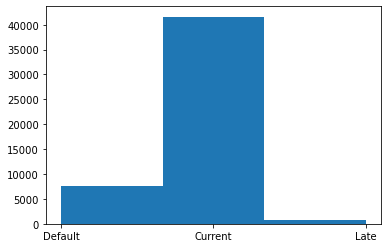

In [6]:
plt.hist(df.status, bins = 3)
plt.show()

In [7]:
print('Percent of data that is Status late', len(df[df.status == 'Late']) / len(df.status)  * 100)

Percent of data that is Status late 1.6241299303944314


In [8]:
df = df[df['status'] != 'Late']

In [9]:
df['term'] = df['term'].str.replace('months', '')
df['term'] = df['term'].str.replace(' ', '').astype(int)

In [10]:
df['verified'] = df['verified'].replace(['Source Verified'], 'Verified')
df = df.drop(['totalPaid'], axis=1)

**Next I wanted to check what correlations exist in the data. Since there was a 99% correlation between totalBal and totalLim, I removed the totalLim feature as it doesn't provide additional information.**

In [11]:
df.corr()

,loanID,amount,term,rate,payment,income,debtIncRat,delinq2yr,inq6mth,openAcc,...,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalLim,totalRevBal,totalBcLim,totalIlLim
loanID,1.000000,0.011347,0.015104,-0.062714,-0.002044,0.001370,0.039358,-0.007174,-0.065709,0.013369,...,-0.009552,0.019673,0.025540,-0.012510,0.019407,-0.024702,-0.005102,0.016821,0.021486,0.016896
amount,0.011347,1.000000,0.406041,0.127375,0.942906,0.420427,0.022337,-0.003559,-0.040007,0.194948,...,0.332381,0.367228,-0.013352,0.242338,0.204716,0.057849,0.359046,0.290691,0.396589,0.200652
term,0.015104,0.406041,1.000000,0.428882,0.131309,0.064657,0.106371,-0.000462,-0.012972,0.086629,...,0.113061,0.078685,0.031858,0.082048,0.007817,0.066625,0.111153,0.116212,0.079023,0.093372
rate,-0.062714,0.127375,0.428882,1.000000,0.112248,-0.111520,0.174507,0.052136,0.226228,-0.012470,...,-0.072720,-0.187320,0.206629,-0.070156,-0.292033,0.246555,-0.108404,-0.013991,-0.249715,-0.018182
payment,-0.002044,0.942906,0.131309,0.112248,1.000000,0.413210,0.006736,0.003306,-0.005883,0.178910,...,0.302433,0.336228,0.004489,0.218249,0.176039,0.068793,0.326815,0.265884,0.357937,0.179207
income,0.001370,0.420427,0.064657,-0.111520,0.413210,1.000000,-0.230197,0.057098,0.036539,0.167251,...,0.530317,0.373552,0.053823,0.411404,0.184859,0.000230,0.552677,0.412034,0.339900,0.333228
debtIncRat,0.039358,0.022337,0.106371,0.174507,0.006736,-0.230197,1.000000,-0.022105,-0.003714,0.289991,...,-0.015867,0.084328,0.161752,-0.140427,-0.064008,0.173847,-0.002349,0.277049,0.046283,0.307124
delinq2yr,-0.007174,-0.003559,-0.000462,0.052136,0.003306,0.057098,-0.022105,1.000000,0.025509,0.037824,...,0.063617,-0.055367,-0.063626,0.057286,-0.052053,-0.015753,0.066265,0.029360,-0.080642,0.065045
inq6mth,-0.065709,-0.040007,-0.012972,0.226228,-0.005883,0.036539,-0.003714,0.025509,1.000000,0.132900,...,0.018214,-0.000827,0.267648,-0.031715,-0.003442,-0.074966,0.018413,0.033557,-0.026468,0.046731
openAcc,0.013369,0.194948,0.086629,-0.012470,0.178910,0.167251,0.289991,0.037824,0.132900,1.000000,...,0.252283,0.387101,0.468600,-0.113418,0.279796,-0.106706,0.289408,0.417054,0.344114,0.368991


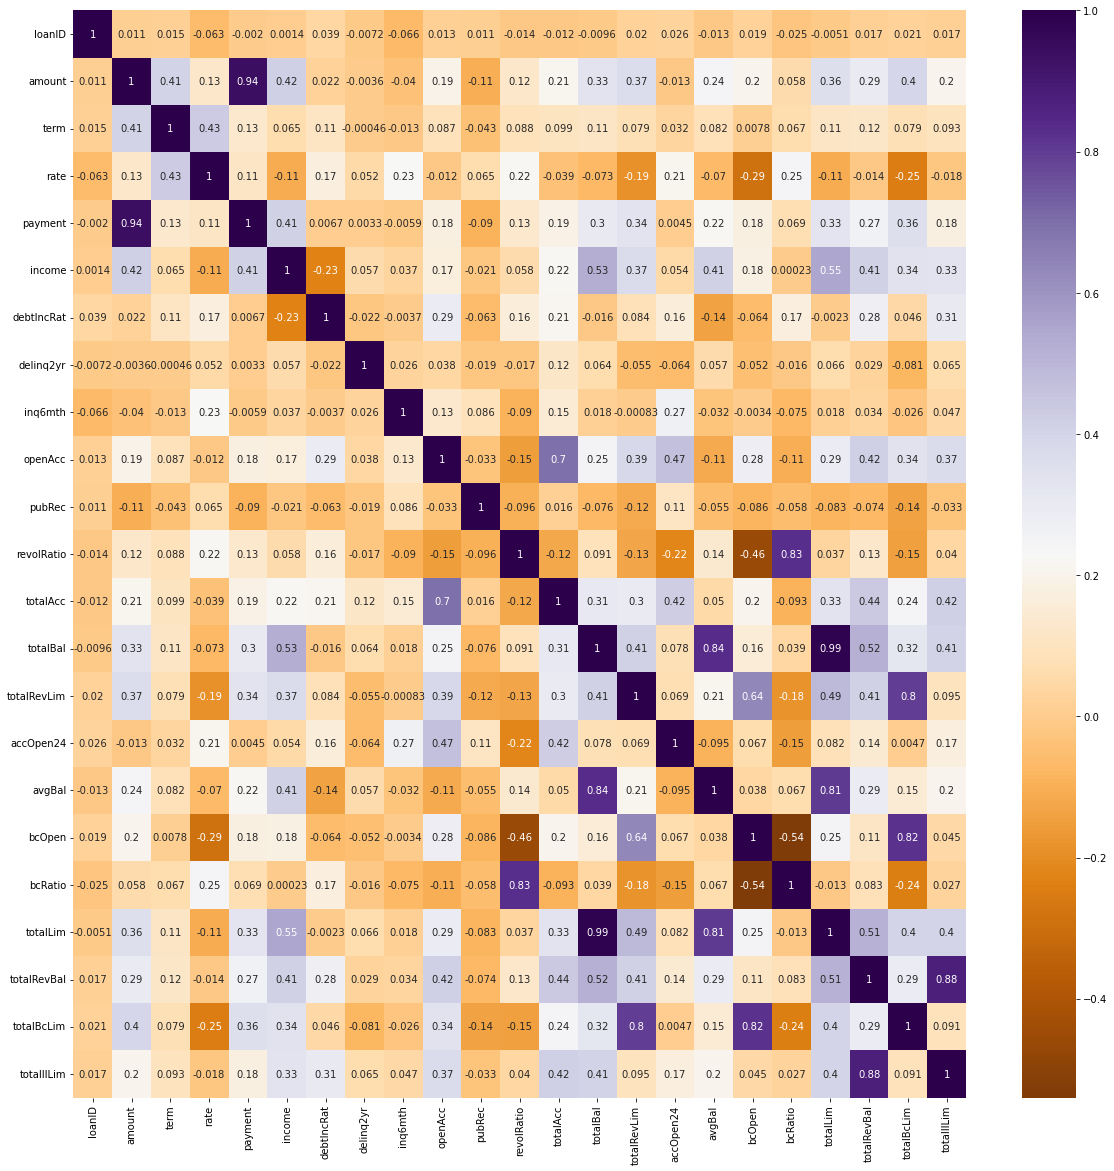

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True, cmap='PuOr')
plt.show()

In [13]:
df = df.drop(['totalLim'], axis=1)

**I was curios about a possible relation between loan status and 'debtIncRat'. Looks like is a slighly higher trend for those who default.**

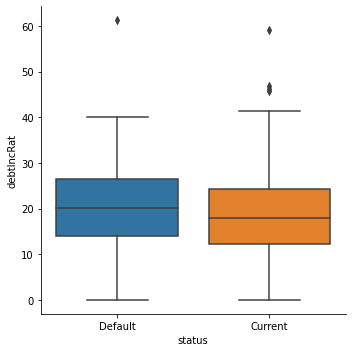

In [14]:
sns.catplot(data=df, x="status", y='debtIncRat', kind="box")
plt.show()

**I wanted to see if there was a difference in defaults based on home ownership. Looks like home owners and those with mortages are muhc more prone to defult than those that rent.**

In [15]:
df.home.unique()

array(['RENT', 'MORTGAGE', 'OWN'], dtype=object)

In [16]:
rent = df[(df['home'] == 'RENT') & (df['status'] == 'Default')]
mortgage = df[(df['home'] == 'MORTGAGE') & (df['status'] == 'Default')]
own = df[(df['home'] == 'OWN') & (df['status'] == 'Default')]

home_values = pd.DataFrame({'home': ['OWN', 'MORTGAGE', 'RENT'], 'default': [len(rent), len(mortgage), len(own)]})
home_totals = pd.DataFrame(df['home'].value_counts()).reset_index()
home_totals.rename(columns = {'index':'home', 'home':'count'}, inplace = True)

home_summary = pd.merge(home_values, home_totals)
home_summary['%'] = (100*home_summary['default']/home_summary['count']).round(2)
home_summary = home_summary.sort_values(by=['%'], ascending=False)

In [17]:
home_summary

,home,default,count,%
0,OWN,3473,5170,67.18
1,MORTGAGE,3303,24698,13.37
2,RENT,804,19316,4.16


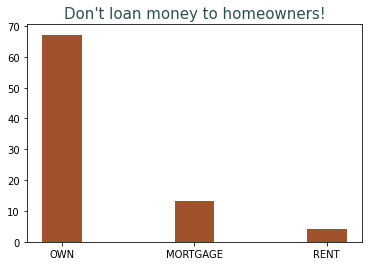

In [18]:
y_pos = np.arange(len(home_summary['home']))
plt.bar(y_pos, home_summary['%'], width = .3, color='sienna')
plt.xticks(y_pos, home_summary['home'])
plt.title("Don't loan money to homeowners!", color='darkslategrey', size=15)

plt.show()

**I wanted to try the same experiment with the reason the loan was originated. I speculated that debt consolodation would be the feature with the highest percentage of defaults. Turns out Small Business loans were by far the highest.**

In [19]:
df.reason.unique()

array(['credit_card', 'debt_consolidation', 'other', 'car',
       'home_improvement', 'vacation', 'medical', 'small_business',
       'house', 'moving', 'major_purchase', 'renewable_energy', 'wedding'],
      dtype=object)

In [20]:
credit_card = df[(df['reason'] == 'credit_card') & (df['status'] == 'Default')]
debt_consolidation = df[(df['reason'] == 'debt_consolidation') & (df['status'] == 'Default')]
other = df[(df['reason'] == 'other') & (df['status'] == 'Default')]
car = df[(df['reason'] == 'car') & (df['status'] == 'Default')]
home_improvement = df[(df['reason'] == 'home_improvement') & (df['status'] == 'Default')]
vacation = df[(df['reason'] == 'vacation') & (df['status'] == 'Default')]
medical = df[(df['reason'] == 'medical') & (df['status'] == 'Default')]
small_business = df[(df['reason'] == 'small_business') & (df['status'] == 'Default')]
house = df[(df['reason'] == 'house') & (df['status'] == 'Default')]
moving = df[(df['reason'] == 'moving') & (df['status'] == 'Default')]
major_purchase = df[(df['reason'] == 'major_purchase') & (df['status'] == 'Default')]
renewable_energy = df[(df['reason'] == 'renewable_energy') & (df['status'] == 'Default')]
wedding = df[(df['reason'] == 'wedding') & (df['status'] == 'Default')]
# df.groupby('status')['totalAcc'].count()

In [21]:
values = pd.DataFrame({'reason':['credit_card', 'debt_consolidation', 'other', 'car','home_improvement', 
                                 'vacation', 'medical', 'small_business',
                                 'house', 'moving', 'major_purchase', 'renewable_energy', 'wedding'],
                       'defaults':[len(credit_card), len(debt_consolidation), len(other), len(car),len(home_improvement), 
                        len(vacation), len(medical), len(small_business), len(house), len(moving), len(major_purchase), len(renewable_energy), len(wedding)]})
    

In [22]:
total_values = pd.DataFrame(df['reason'].value_counts()).reset_index()
total_values

,index,reason
0,debt_consolidation,29412
1,credit_card,11742
2,home_improvement,2886
3,other,2198
4,major_purchase,896
5,medical,498
6,small_business,423
7,car,376
8,moving,284
9,vacation,269


In [23]:
total_values.rename(columns = {'index':'reason', 'reason':'count'}, inplace = True)

In [24]:
reason_summary = pd.merge(values, total_values)
reason_summary['%'] = (100*reason_summary['defaults']/reason_summary['count']).round(2)
reason_summary = reason_summary.sort_values(by=['%'], ascending=False)
reason_summary.reset_index(inplace=True)

In [25]:
reason_summary.drop(['index'], axis=1)

,reason,defaults,count,%
0,small_business,112,423,26.48
1,moving,61,284,21.48
2,medical,94,498,18.88
3,house,29,162,17.90
4,vacation,47,269,17.47
5,other,370,2198,16.83
6,renewable_energy,6,36,16.67
7,debt_consolidation,4797,29412,16.31
8,major_purchase,127,896,14.17
9,home_improvement,405,2886,14.03


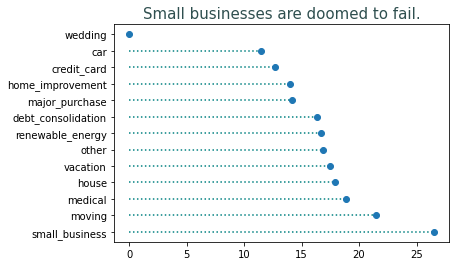

In [26]:
my_range=range(1,len(reason_summary.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=reason_summary['%'], color='teal', linestyle='dotted')
plt.plot(reason_summary['%'], my_range, "o")
plt.yticks(my_range, reason_summary['reason'])
plt.title("Small businesses are doomed to fail.", color='darkslategrey', size=15)
plt.show()

**I separated Current & Default into their own dataframes and created samples of 1000 from each for easier visualization. I did a quick histogram of the separated dataframes to compare to each other.**

In [27]:
default = df[df['status']=='Default']
current = df[df['status']=='Current']

default_sample = default.sample(1000)
current_sample = current.sample(1000)
df_sample=df.sample(1000)

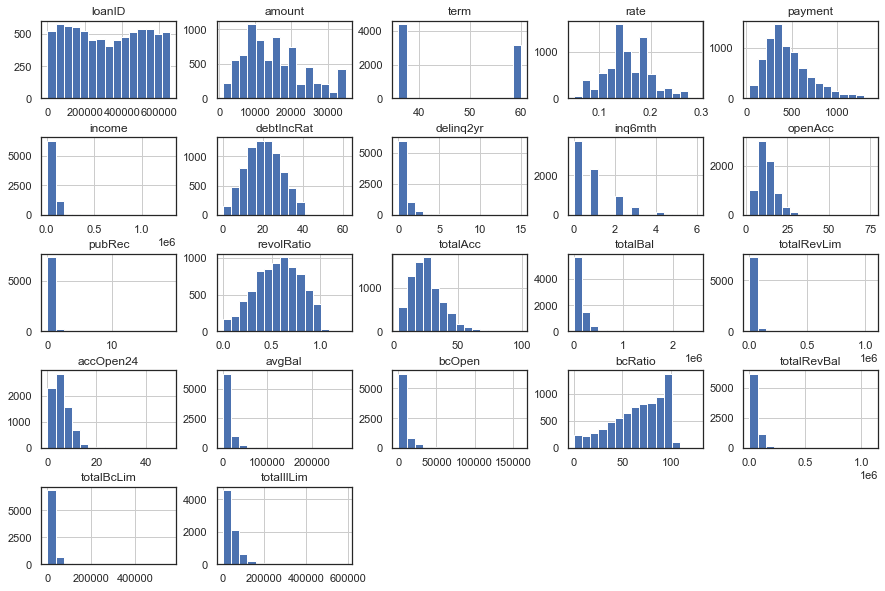

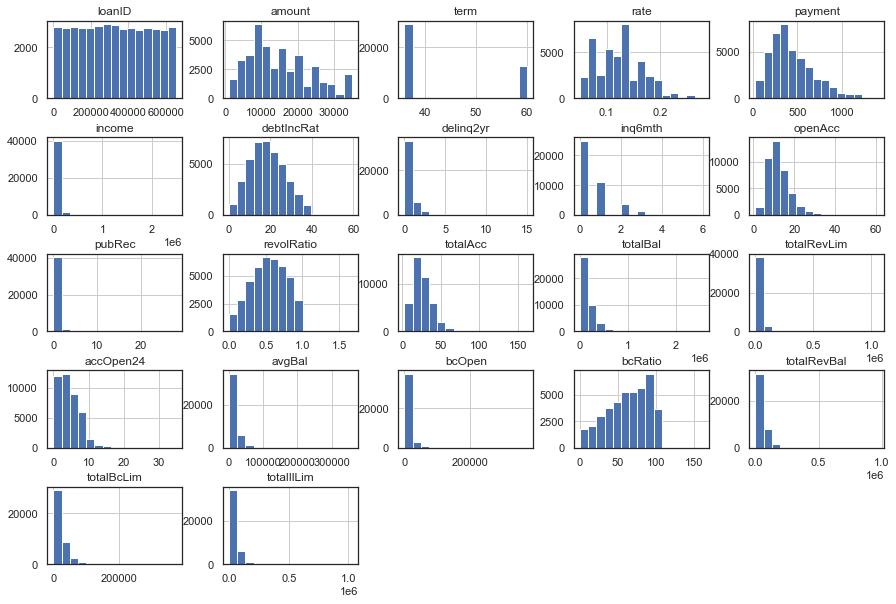

In [67]:
figsize=(10, 10)
default.hist(figsize=(15, 10), bins=15)
plt.subplots_adjust(hspace=0.5)
current.hist(figsize=(15, 10), bins=15)
plt.subplots_adjust(hspace=0.5)
plt.show()

**I tried using describe on each of the newly created dataframes and then subtracted them from each other to see if there were any large diferences. Becuase the data is scaled very differently, it was hard to eaily see what differences might be important. And beyond that, because the data is not normally distributed, these metrics are not as helpful.**

In [28]:
default_info = default.describe()
current_info = current.describe()

default_info = default_info.drop('count')
current_info = current_info.drop('count')

default_info = default_info.drop(labels='loanID', axis=1)
current_info = current_info.drop(labels='loanID', axis=1)

In [29]:
default_info.subtract(current_info, axis = 1).T

,mean,std,min,25%,50%,75%,max
amount,394.428188,-151.896408,0.0,1200.0000,925.00,0.0000,0.00
term,2.803452,0.807710,0.0,0.0000,0.00,0.0000,0.00
rate,0.029144,0.001172,0.0,0.0400,0.03,0.0300,0.01
payment,13.913888,-2.020871,2.2,18.7300,16.65,0.0000,-24.65
income,-8282.249999,-7977.488842,4796.0,-5000.0000,-5000.00,-10583.2500,-1200000.00
debtIncRat,1.973283,0.265429,0.0,1.8075,2.37,2.2225,2.02
delinq2yr,0.024711,0.057411,0.0,0.0000,0.00,0.0000,0.00
inq6mth,0.219475,0.131919,0.0,0.0000,1.00,0.0000,0.00
openAcc,0.328932,0.322006,1.0,0.0000,0.00,0.0000,15.00
pubRec,0.039927,0.037349,0.0,0.0000,0.00,0.0000,-9.00


**I looked at the difference between the 50th percentiles (medians). Looks like there are some noticable features that might be relevant later on.**

In [30]:
median_diffs = pd.DataFrame(default.median() - current.median())
median_diffs.columns = ['Diffs']
median_diffs = median_diffs.drop(['loanID', 'term'], axis=0)
median_diffs.T

,amount,rate,payment,income,debtIncRat,delinq2yr,inq6mth,openAcc,pubRec,revolRatio,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
Diffs,925.0,0.03,16.65,-5000.0,2.37,0.0,1.0,0.0,0.0,0.02,0.0,-24105.5,-3500.0,1.0,-2003.5,-1346.5,4.3,-591.0,-3200.0,210.0


**I looked at why people were getting a loan vs. their income. I used status to further separate the data on the plot.**

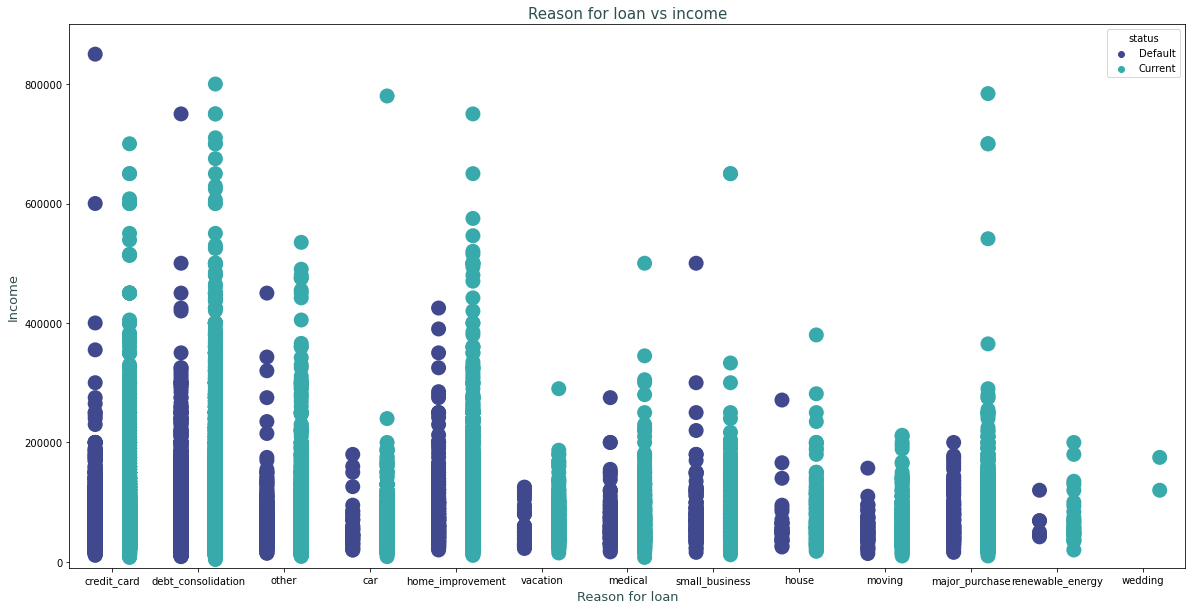

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
sns.stripplot(x='reason', y="income", data=df, hue='status', jitter=False, size=15, palette="mako", dodge=True, marker='o', native_scale=False)
plt.title('Reason for loan vs income', loc='center', color='darkslategray', size=15)
plt.ylim(-10000,900000)
plt.xlabel('Reason for loan', color='darkslategray', size=13)
plt.ylabel('Income', color='darkslategray', size=13)
plt.show()

**Below I used sampled data to scatterplot the revolRatio (Revolving Ratio) against the totalBcLim (total credit limits of credit cards)and added a regression line for both Current & Defaul loans.**

In [48]:
x1, y1 = default_sample['revolRatio'], default_sample['totalBcLim']
x2, y2 = current_sample['revolRatio'], current_sample['totalBcLim']

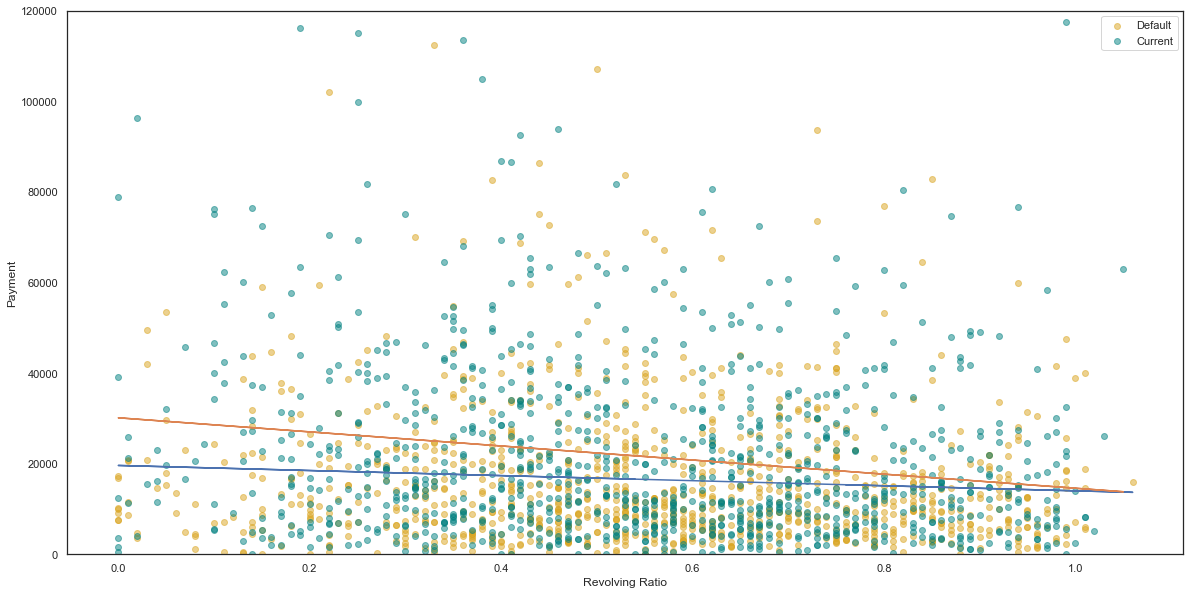

In [60]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x1, y1, color='goldenrod', label='Default', alpha=.5)
ax.scatter(x2, y2, color='teal', label = 'Current', alpha=.5)

m, b = np.polyfit(x1, y1, 1)
plt.plot(x1, m*x1+b)

m, b = np.polyfit(x2, y2, 1)
plt.plot(x2, m*x2+b)
plt.ylim(-20,120000)
ax.legend()
ax.set_xlabel('Revolving Ratio')
ax.set_ylabel('Payment')
plt.show()

**I wanted to sort the defaults by state to see if any states in particular had a higher percentage of defaults. I used a bar plot to visualize the results.**

In [34]:
df['status_num'] = df['status']
df['status_num'] = df['status_num'].replace(['Current', 'Default'], [0, 1])

In [35]:
df.status_num = df.status_num
state_counts = df.groupby('state').agg({'status_num': 'sum'}).reset_index()

state_num = df.groupby('state')['state'].count().reset_index(name='count')

state_summary = pd.merge(state_counts, state_num)
state_summary.columns=['state', 'number_of_defaults', 'total_loans']
state_summary['%_of_defaults'] = state_summary['number_of_defaults']/state_summary['total_loans']
state_summary = state_summary.sort_values(by=['%_of_defaults'], ascending=False).reset_index()

In [36]:
state_summary

,index,state,number_of_defaults,total_loans,%_of_defaults
0,0,AK,24,114,0.210526
1,30,NM,56,275,0.203636
2,34,OK,94,474,0.198312
3,31,NV,130,676,0.192308
4,23,MS,48,253,0.189723
5,8,DE,25,136,0.183824
6,32,NY,734,4037,0.181818
7,2,AR,66,370,0.178378
8,22,MO,142,798,0.177945
9,40,TN,139,783,0.177522


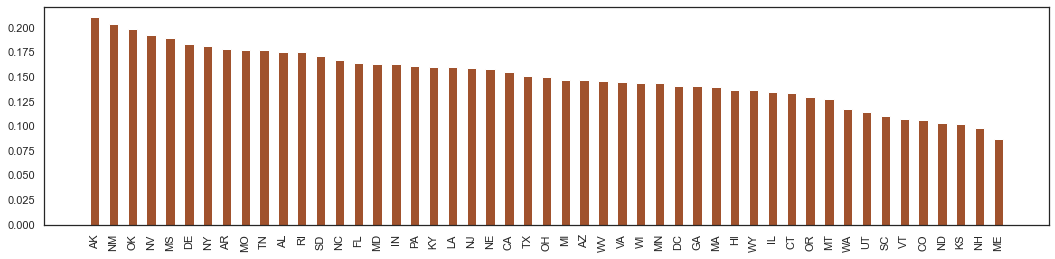

In [59]:
plt.figure(figsize=(18, 4))

y_pos = np.arange(len(state_summary['state']))

plt.bar(y_pos, state_summary['%_of_defaults'], width = .5, color='sienna')

plt.xticks(y_pos, state_summary['state'], rotation=90)

plt.show()

**I tried another scatter plot to look for any patterns in the data. I plotted the totalAcc (total number of credit lines) against the debtIncRat (debt to income ratio).**

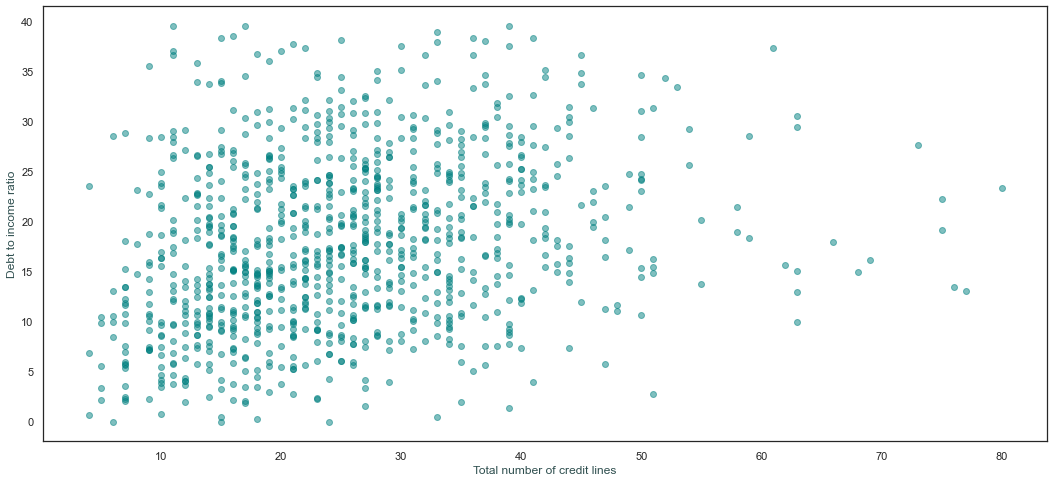

In [65]:
plt.figure(figsize=(18, 8))
plt.plot( 'totalAcc', 'debtIncRat', data=df_sample, linestyle='none', marker='o', alpha=0.5, color='teal')
plt.xlabel('Total number of credit lines', color='darkslategrey')
plt.ylabel('Debt to income ratio', color='darkslategrey')
plt.show()

**I used a histogram to plot the number of records across the debtIncRat (debt to income ratio). By splitting Default & Current, I'm able to see a trend of where current loans outnumber defaults at the lower debtIncRat and then defaults outnumber currents at the high debIncRat. It's hard to see so I tried to mirror the plot.**

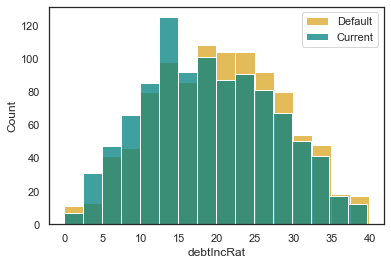

In [57]:
sns.set_theme(style="white")

sns.histplot(data=default_sample, x="debtIncRat", color='goldenrod', label='Default', bins=16)
sns.histplot(data=current_sample, x="debtIncRat", color='teal', label='Current', bins=16)

plt.legend()
plt.show()

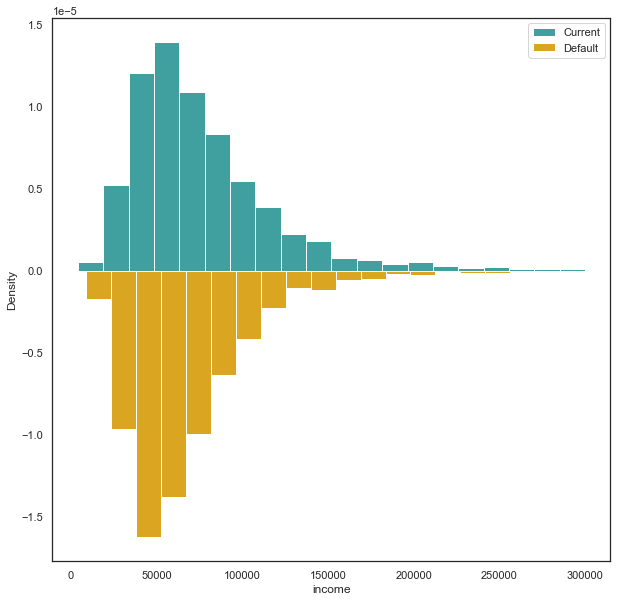

In [66]:
# Remove outliers
default_o = df[(df['status'] == 'Default') & (df['income'] <= 300000)]
current_o = df[(df['status'] == 'Current') & (df['income'] <= 300000)]


plt.figure(figsize=(10, 10))

# plot histogram chart for var1
sns.histplot(data=current_o['income'], stat="density", bins=20, color='teal', label='Current', edgecolor='white')

# plot histogram chart for var2

# get positions and heights of bars
heights, bins = np.histogram(default_o['income'], density=True, bins=20)
# multiply by -1 to reverse it
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos =( bins[:-1] + bin_width / 2)

# plot
plt.bar(bin_pos, heights, width=bin_width, color='goldenrod', label='Default', edgecolor='white')

# show the graph
plt.legend()
plt.show()